# NOTE: The backend has changed since this notebook was developed. It will most likely not run without some minor tweaks.

### Estimating uncertainty in a BNN using Laplace Approximation (regression task)

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")

from src.inference.laplace import laplace_model
from src import evaluate
from src.evaluate import evaluate_regr
import src.utils
from src.utils import util
from src.utils import data_loaders
from src.utils.domain_split import hyperplane_split
from src.train_test import fit_regr
from src.train_test import test_regr
from src.model import MLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from laplace import Laplace, marglik_training
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN

#npr.seed(42)
#torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read airfoil data
df = pd.read_csv("data/regression/airfoil.csv")
D = df.values

# Split domain
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1)

# Data processing
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_features = X_train.shape[1]
n_hidden_1 = 30
n_hidden_2 = 30
n_epochs = 1000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size_train = 64
batch_size_test = 64

# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)

Found random direction n = [ 0.51640181 -0.32161427  0.37055607  0.15046263 -0.37381268 -0.57463615]
Found split with ratio r = 0.20093147039254824


### Standard NN model (2 hidden layers with 30 neurons each, ReLU activation function)

In [2]:
airfoil_model = MLP(n_features, 1, [128, 32, ], 'tanh').to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
train_loss = train_losses[-1]

print("Average Train MSE Loss:", train_loss / len(X_train))
print(f"Total train loss = {train_loss:.5f}")  

Average Train MSE Loss: 2.402608515694737e-07
Total train loss = 0.00023


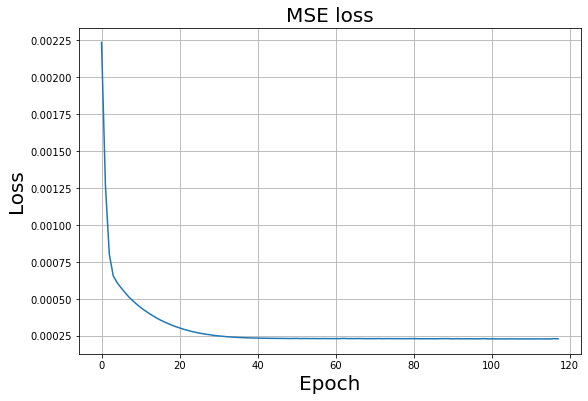

In [3]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [4]:
test_loss = test_regr(airfoil_model, loss_function, test_loader, verbose=1, return_loss=True)

print(f"Total test loss = {test_loss:.5f}")

Average Test MSE Loss: 0.00024194
Total test loss = 0.00024


In [5]:
OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, verbose=1, return_loss=True)
avg_OOD_loss = OOD_loss / len(X_OOD)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Total OOD loss = {OOD_loss:.5f}")
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / ( train_loss / len(X_train) ) : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / ( test_loss / len(X_test) ) : .3f}")

Average Test MSE Loss: 0.00082592
Average OOD loss = 0.0000027348
Total OOD loss = 0.00083
Average OOD loss to train loss ratio:  11.383
Average OOD loss to test loss ratio:  2.724


### Laplace approximation of the full network with full Hessian computation

In [6]:
LA = laplace_model(airfoil_model, 'regression', subset_of_weights='all', hessian_structure='kron', sigma_noise=1e-2)
LA.fit(train_loader)

LA.optimize_prior_precision(method='marglik')

In [7]:
posterior_samples = 1000

train_eval = evaluate.evaluate_regr(LA, train_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Train data')
test_eval = evaluate.evaluate_regr(LA, test_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Test data')
OOD_eval = evaluate.evaluate_regr(LA, OOD_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, OOD data')

print("Train evaluation:")
for key,  value in train_eval.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key, value in test_eval.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key, value in OOD_eval.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Laplace approximation full network
Evaluated on: Airfoil Dataset, Train data
Neural network: [128, 32]
Number of posterior samples: 1000
Average NLPD: 1.3386577
SD of NLPD: 0.03432238
Total NLPD: 1285.1113
Average loss: 0.00022498536952
Total loss: 0.2159859547391534
Average standard deviation: NA

Test evaluation:
Inference type: Laplace approximation full network
Evaluated on: Airfoil Dataset, Test data
Neural network: [128, 32]
Number of posterior samples: 1000
Average NLPD: 1.3288031
SD of NLPD: 0.031082695
Total NLPD: 320.24152
Average loss: 0.0002469809347169
Total loss: 0.0595224052667618
Average standard deviation: NA

OOD evaluation:
Inference type: Laplace approximation full network
Evaluated on: Airfoil Dataset, OOD data
Neural network: [128, 32]
Number of posterior samples: 1000
Average NLPD: 1.3634158
SD of NLPD: 0.036216192
Total NLPD: 411.7516
Average loss: 0.0008305121114515
Total loss: 0.2508146576583386
Average standard deviation: NA


### Last Layer Laplace Approximation with Kronecker factored log likelihood Hessian approximation

In [20]:
airfoil_model = copy.deepcopy(airfoil_model_NN)

In [21]:
llla = Laplace(airfoil_model, 'regression', sigma_noise=0.1)
llla.fit(train_loader)

llla.optimize_prior_precision(method='marglik')

In [22]:
posterior_samples = 10000

train_eval = evaluate_regr_laplace(llla, train_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Train data')
test_eval = evaluate_regr_laplace(llla, test_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Test data')
OOD_eval = evaluate_regr_laplace(llla, OOD_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, OOD data')

print("Train evaluation:")
for key,  value in train_eval.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key, value in test_eval.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key, value in OOD_eval.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Airfoil Dataset, Train data
Number of posterior samples: 10000
Average NLPD: 10.952158
SD of NLPD: 32.267666
Total NLPD: 10514.071
Average loss: 6.865392279e-05
Total loss: 0.0659077658783644

Test evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Airfoil Dataset, Test data
Number of posterior samples: 10000
Average NLPD: 11.762924
SD of NLPD: 31.435274
Total NLPD: 2834.8645
Average loss: 7.235944074e-05
Total loss: 0.0174386252183467

OOD evaluation:
Inference type: Last Layer Laplace Approximation
Evaluated on: Airfoil Dataset, OOD data
Number of posterior samples: 10000
Average NLPD: 25.409819
SD of NLPD: 33.803543
Total NLPD: 7673.765
Average loss: 0.0003027984477728
Total loss: 0.0914451312273741


### Jointly optimize MAP and hyperparameters using online empirical Bayes

The method optimizes the neural network and the hyperparameters in an interleaved way and returns an optimally regularized LA.

1 hour for only 10 epochs, this is very slow

In [32]:
%%time

airfoil_model_online = model.airfoil_laplace(n_features, n_hidden_1, n_hidden_2).to(device)

la, model, margliks, losses = marglik_training(
    model=model.to(device), train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=2, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

CPU times: total: 7h 32min 20s
Wall time: 57min 8s


In [39]:
posterior_samples = 1000

train_eval = evaluate_regr_laplace(la, train_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Train data')
test_eval = evaluate_regr_laplace(la, test_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, Test data')
OOD_eval = evaluate_regr_laplace(la, OOD_loader, loss_function, posterior_samples, device=device, dataset='Airfoil Dataset, OOD data')

print("Train evaluation:")
for key,  value in train_eval.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key, value in test_eval.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key, value in OOD_eval.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Laplace Approximation
Evaluated on: Airfoil Dataset, Train data
Number of posterior samples: 1000
Average NLPD: 3.4415545
SD of NLPD: 0.14727224
Total NLPD: 3303.892
Average loss: 0.0001808679517126
Total loss: 0.1736332336440682

Test evaluation:
Inference type: Laplace Approximation
Evaluated on: Airfoil Dataset, Test data
Number of posterior samples: 1000
Average NLPD: 3.3904643
SD of NLPD: 0.13821094
Total NLPD: 817.10187
Average loss: 0.0001746551423523
Total loss: 0.0420918893069029

OOD evaluation:
Inference type: Laplace Approximation
Evaluated on: Airfoil Dataset, OOD data
Number of posterior samples: 1000
Average NLPD: 3.5216594
SD of NLPD: 0.11160628
Total NLPD: 1063.5411
Average loss: 0.0001472409287258
Total loss: 0.0444667604751885
